# Import

In [1]:
%load_ext autoreload
%autoreload 2
import volpick.data
import volpick
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import time
import datetime
from pathlib import Path
from obspy import read
from collections import namedtuple
from volpick.data.utils import freqency_index
import seisbench.data as sbd
from volpick.data.utils import extract_events, exclude_close_events
from volpick.data import AlaskaDataset,NoiseData

import HinetPy
from HinetPy.utils import to_datetime, point_inside_circular, point_inside_box
from volpick.data.data import HinetClient2
from datetime import datetime
from datetime import timedelta

def create_noise_table(base_catalog,time_difference_limit=3600*24):
    stations=np.unique(base_catalog.apply(lambda x: (x["station_network_code"],x["station_code"],x["station_location_code"],x["trace_channel"]),axis=1).values)
    np.random.seed(100)

    if len(stations)>300:
        np.random.shuffle(stations)
        stations=stations[:300]
    
    # conservertive_event_end
    def get_event_end(x):
        if pd.notna(x["trace_p_arrival_time"]) and pd.notna(x["trace_s_arrival_time"]):
            if x["trace_p_arrival_time"]<x["trace_s_arrival_time"]:
                return x["trace_p_arrival_time"]+(x["trace_s_arrival_time"]-x["trace_p_arrival_time"])*5+60
            else:
                return x["source_origin_time"]+600
        elif pd.notna(x["trace_p_arrival_time"]):
            return x["trace_p_arrival_time"]+600
        else:
            return x["source_origin_time"]+600
    
    subcatalogs=[]
    for station in stations:    
        subcatalog=base_catalog[base_catalog.apply(lambda x: (x["station_network_code"],x["station_code"],x["station_location_code"],x["trace_channel"]),axis=1)==station].copy()
        subcatalog["source_origin_time"]=subcatalog["source_origin_time"].apply(lambda x: UTCDateTime(x) if pd.notna(x) else np.nan)
        subcatalog["trace_p_arrival_time"]=subcatalog["trace_p_arrival_time"].apply(lambda x: UTCDateTime(x) if pd.notna(x) else np.nan)
        subcatalog["trace_s_arrival_time"]=subcatalog["trace_s_arrival_time"].apply(lambda x: UTCDateTime(x) if pd.notna(x) else np.nan)
        subcatalog.sort_values(by=["source_origin_time"], inplace=True)
        subcatalog["event_end"]=subcatalog.apply(get_event_end,axis=1)

        forward_event_time_diff = (subcatalog["source_origin_time"].values[1:]-subcatalog["event_end"].values[:-1]).astype(float)
        forward_event_time_diff=np.append(forward_event_time_diff,np.nan)
        subcatalog["forward_event_time_difference"]=forward_event_time_diff
        subcatalog["next_event_origin_time"]=np.append(subcatalog["source_origin_time"][1:].values,np.nan)

        subcatalog.sort_values(by=["forward_event_time_difference"], ascending=False, inplace=True)
        subcatalog=subcatalog[pd.notna(subcatalog["forward_event_time_difference"])&(subcatalog["forward_event_time_difference"]>time_difference_limit)]
        subcatalog=subcatalog.iloc[:500].copy()
        subcatalog.reset_index(inplace=True)
        subcatalogs.append(subcatalog)
    result=pd.concat(subcatalogs,ignore_index=True)
    return result

In [6]:
alsk=AlaskaDataset()

The default saving directory is used: /home/zhongyiyuan/DATA/my_data/Alaska
/home/zhongyiyuan/DATA/my_data/Alaska exists


In [302]:
ak_whole_catalog=alsk.read(format="csv")
print(f"The whole catalog includes {len(ak_whole_catalog)} waveforms, where there are")
print(f""" {len(ak_whole_catalog[ak_whole_catalog["source_type"]!="lp"])} waveforms for regular earthquakes""")
print(f""" {len(ak_whole_catalog[ak_whole_catalog["source_type"]=="lp"])} waveforms for long-period earthquakes""")

The whole catalog includes 882415 waveforms, where there are
 785281 waveforms for regular earthquakes
 97134 waveforms for long-period earthquakes


In [2]:
hawaii2 = volpick.data.HawaiiDataset(
    root_folder_name="hawaii2012to2021",
    cat_file_name="hawaii_catalog2012to2021",
)
hw_whole_catalog2=hawaii2.read(format="csv")

The default saving directory is used: /home/zhongyiyuan/DATA/my_data/hawaii2012to2021
/home/zhongyiyuan/DATA/my_data/hawaii2012to2021 exists


In [306]:
hw_stations=np.unique(hw_whole_catalog2.apply(lambda x: (x["station_network_code"],x["station_code"],x["station_location_code"],x["trace_channel"]),axis=1).values)

In [309]:
result2=create_noise_table(base_catalog=hw_whole_catalog2)

In [314]:
len(hw_stations)

250

In [17]:
alsk_lp_metadata=pd.read_csv("/home/zhongyiyuan/DATA/my_datasets_seisbench/alaska/metadata_ak_lp.csv")
alsk_vt_metadata=pd.read_csv("/home/zhongyiyuan/DATA/my_datasets_seisbench/alaska/metadata_ak_rg.csv")
alsk_metadata=pd.concat([alsk_lp_metadata,alsk_vt_metadata],ignore_index=True)

In [18]:
alsk_metadata.columns

Index(['source_id', 'source_origin_time', 'source_latitude_deg',
       'source_longitude_deg', 'source_depth_km', 'source_magnitude',
       'source_magnitude_type', 'source_type', 'station_network_code',
       'station_code', 'station_location_code', 'trace_channel',
       'station_latitude_deg', 'station_longitude_deg', 'station_elevation_m',
       'station_epicentral_distance_m', 'path_azimuth_deg',
       'path_back_azimuth_deg', 'trace_p_arrival_time', 'trace_s_arrival_time',
       'trace_p_max_weight', 'trace_s_max_weight', 'trace_p_first_motion',
       'trace_name', 'trace_sampling_rate_hz', 'trace_has_spikes',
       'trace_start_time', 'trace_p_arrival_sample', 'trace_p_status',
       'trace_s_arrival_sample', 'trace_s_status', 'trace_snr_db',
       'trace_mean_snr_db', 'trace_frequency_index', 'split',
       'trace_name_original', 'source_frequency_index'],
      dtype='object')

In [ ]:
alsk_lp_metadata

In [166]:
stations=np.unique(alsk_metadata.apply(lambda x: (x["station_network_code"],x["station_code"],x["station_location_code"],x["trace_channel"]),axis=1).values)

In [207]:
stations

array([('AK', 'ATKA', '--', 'BH'), ('AK', 'CNP', '--', 'BH'),
       ('AK', 'FALS', '--', 'BH'), ('AK', 'HOM', '--', 'BH'),
       ('AK', 'NIKH', '--', 'BH'), ('AK', 'NIKO', '--', 'BH'),
       ('AK', 'SKN', '--', 'BH'), ('AK', 'SLK', '--', 'BH'),
       ('AK', 'SSN', '--', 'BH'), ('AK', 'UNV', '--', 'BH'),
       ('AK', 'UNV', '--', 'BN'), ('AT', 'AKUT', '--', 'BH'),
       ('AT', 'CHGN', '--', 'BH'), ('AT', 'PMR', '--', 'BH'),
       ('AT', 'SDPT', '--', 'BH'), ('AV', 'ACH', '--', 'BH'),
       ('AV', 'ACH', '--', 'EH'), ('AV', 'ADAG', '--', 'EH'),
       ('AV', 'AHB', '--', 'EH'), ('AV', 'AJAX', '--', 'EH'),
       ('AV', 'AKBB', '--', 'BH'), ('AV', 'AKGG', '--', 'BH'),
       ('AV', 'AKLV', '--', 'BH'), ('AV', 'AKMO', '--', 'BH'),
       ('AV', 'AKRB', '--', 'BH'), ('AV', 'AKS', '--', 'EH'),
       ('AV', 'AKSA', '--', 'BH'), ('AV', 'AKV', '--', 'BH'),
       ('AV', 'AKV', '--', 'EH'), ('AV', 'AMKA', '--', 'BH'),
       ('AV', 'ANCK', '--', 'BH'), ('AV', 'ANCK', '--', 'EH'),
      

In [209]:
np.random.shuffle(stations)

In [280]:
len(result)

24826

(-500.05, 10501.05, -0.19677219968256443, 4.132216193333853)

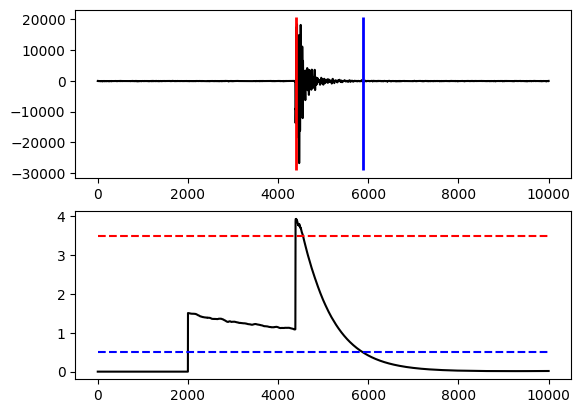

In [283]:
import matplotlib.pyplot as plt

import obspy
from obspy.clients.fdsn import Client
from obspy.signal.trigger import recursive_sta_lta, trigger_onset


# Retrieve waveforms via FDSNWS
client = Client("LMU")
t = obspy.UTCDateTime("2009-08-24 00:19:45")
st = client.get_waveforms('BW', 'RTSH', '', 'EHZ', t, t + 50)

# For convenience
tr = st[0]  # only one trace in mseed volume
df = tr.stats.sampling_rate

# Characteristic function and trigger onsets
cft = recursive_sta_lta(tr.data, int(2.5 * df), int(10. * df))
on_of = trigger_onset(cft, 3.5, 0.5)

# Plotting the results
ax = plt.subplot(211)
plt.plot(tr.data, 'k')
ymin, ymax = ax.get_ylim()
plt.vlines(on_of[:, 0], ymin, ymax, color='r', linewidth=2)
plt.vlines(on_of[:, 1], ymin, ymax, color='b', linewidth=2)
plt.subplot(212, sharex=ax)
plt.plot(cft, 'k')
plt.hlines([3.5, 0.5], 0, len(cft), color=['r', 'b'], linestyle='--')
plt.axis('tight')

In [294]:
on_of[:, 0] / tr.stats.sampling_rate+ tr.times(reftime=tr.stats.starttime)[0]

array([21.93])

In [303]:
len(stations2)

441

In [296]:
on_of.shape

(1, 2)

0.0

In [193]:
stations2=np.unique(ak_whole_catalog.apply(lambda x: (x["station_network_code"],x["station_code"],x["station_location_code"],x["trace_channel"]),axis=1).values)

In [259]:
st=read()

In [274]:
str(st[0].stats.starttime).replace("-","").replace(":","")[2:-4]

'090824T002003.000'

In [254]:
result.columns

Index(['index', 'source_id', 'source_origin_time', 'source_latitude_deg',
       'source_longitude_deg', 'source_depth_km', 'source_magnitude',
       'source_magnitude_type', 'source_type', 'station_network_code',
       'station_code', 'station_location_code', 'trace_channel',
       'trace_p_arrival_time', 'trace_s_arrival_time', 'trace_p_max_weight',
       'trace_s_max_weight', 'trace_p_first_motion', 'event_end',
       'forward_event_time_difference', 'next_event_origin_time'],
      dtype='object')

In [246]:
result=create_noise_table(base_catalog=ak_whole_catalog)

In [313]:
result

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,...,station_location_code,trace_channel,trace_p_arrival_time,trace_s_arrival_time,trace_p_max_weight,trace_s_max_weight,trace_p_first_motion,event_end,forward_event_time_difference,next_event_origin_time
0,0,alk60407578,2008-09-12T02:23:22.060000Z,53.419833,-168.152167,1.35,0.70,ml,le,AV,...,--,EH,NaN,NaN,NaN,NaN,NaN,2008-09-12T02:33:22.060000Z,59209348.80,2010-07-29T09:35:50.860000Z
1,1,alk60956228,2005-02-27T03:41:59.000000Z,53.282167,-168.302667,4.40,1.80,ml,le,AV,...,--,EH,2005-02-27T03:42:04.240000Z,NaN,0.40,NaN,NaN,2005-02-27T03:52:04.240000Z,10593648.09,2005-06-29T18:32:52.330000Z
2,2,alk70738014,2017-02-20T02:01:05.900000Z,53.931333,-167.988167,1.08,1.57,ml,le,AV,...,--,EH,2017-02-20T02:01:16.060000Z,NaN,1.02,NaN,U,2017-02-20T02:11:16.060000Z,9582471.43,2017-06-10T23:59:07.490000Z
3,3,alk60981651,2015-03-19T07:18:24.870000Z,53.210333,-168.384500,0.47,1.70,ml,le,AV,...,--,EH,2015-03-19T07:18:31.980000Z,NaN,0.06,NaN,U,2015-03-19T07:28:31.980000Z,7780029.43,2015-06-17T08:35:41.410000Z
4,4,alk60741868,2006-03-01T07:33:53.840000Z,53.423667,-168.099167,3.27,1.40,ml,le,AV,...,--,EH,2006-03-01T07:33:55.440000Z,NaN,1.12,NaN,NaN,2006-03-01T07:43:55.440000Z,7779359.74,2006-05-30T08:39:55.180000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24821,215,alk61761083,1999-04-06T08:20:57.840000Z,54.616500,-161.269833,14.64,2.60,ml,ot,AV,...,--,EH,1999-04-06T08:21:10.220000Z,1999-04-06T08:21:19.370000Z,1.08,1.08,NaN,1999-04-06T08:22:55.970000Z,94441.29,1999-04-07T10:36:57.260000Z
24822,216,alk61760673,1999-03-26T23:22:18.130000Z,54.770667,-164.187500,0.58,2.50,ml,le,AV,...,--,EH,NaN,NaN,NaN,NaN,NaN,1999-03-26T23:32:18.130000Z,94169.84,1999-03-28T01:41:47.970000Z
24823,217,alk61768883,1999-11-10T11:09:42.670000Z,54.466500,-160.991333,-3.19,3.20,ml,ot,AV,...,--,EH,1999-11-10T11:09:54.020000Z,1999-11-10T11:10:02.930000Z,0.68,1.02,NaN,1999-11-10T11:11:38.570000Z,91393.93,1999-11-11T12:34:52.500000Z
24824,218,alk61768383,1999-11-03T04:00:22.850000Z,54.413833,-161.450167,-3.18,2.60,ml,ot,AV,...,--,EH,1999-11-03T04:00:36.940000Z,NaN,0.74,NaN,NaN,1999-11-03T04:10:36.940000Z,89224.08,1999-11-04T04:57:41.020000Z


In [279]:
result.to_csv("ak_noise_table.csv",index=False)

In [255]:
ak_whole_catalog

,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,station_code,station_location_code,trace_channel,trace_p_arrival_time,trace_s_arrival_time,trace_p_max_weight,trace_s_max_weight,trace_p_first_motion
0,alk61831343,1989-10-12T13:14:35.200000Z,61.451833,-151.236667,13.47,1.10,ml,ot,AV,BGL,--,EH,1989-10-12T13:14:46.390000Z,1989-10-12T13:14:54.990000Z,1.12,0.56,NaN
1,alk61831343,1989-10-12T13:14:35.200000Z,61.451833,-151.236667,13.47,1.10,ml,ot,AV,CGL,--,EH,1989-10-12T13:14:43.170000Z,NaN,1.12,NaN,U
2,alk61831343,1989-10-12T13:14:35.200000Z,61.451833,-151.236667,13.47,1.10,ml,ot,AV,CRP,--,EH,1989-10-12T13:14:44.760000Z,NaN,1.12,NaN,NaN
3,alk61831343,1989-10-12T13:14:35.200000Z,61.451833,-151.236667,13.47,1.10,ml,ot,AV,NCG,--,EH,1989-10-12T13:14:44.000000Z,NaN,1.12,NaN,U
4,alk61831343,1989-10-12T13:14:35.200000Z,61.451833,-151.236667,13.47,1.10,ml,ot,AV,SPU,--,EH,1989-10-12T13:14:44.510000Z,1989-10-12T13:14:51.810000Z,1.12,0.84,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882410,alk65066207,2017-12-31T22:19:25.390000Z,60.647667,-152.687500,5.73,0.23,ml,le,AV,RDSO,--,BH,2017-12-31T22:19:29.240000Z,2017-12-31T22:19:32.120000Z,1.08,1.08,U
882411,alk65066207,2017-12-31T22:19:25.390000Z,60.647667,-152.687500,5.73,0.23,ml,le,AV,RDT,--,EH,2017-12-31T22:19:28.500000Z,NaN,1.08,NaN,D
882412,alk65066207,2017-12-31T22:19:25.390000Z,60.647667,-152.687500,5.73,0.23,ml,le,AV,RDWB,--,BH,2017-12-31T22:19:28.840000Z,2017-12-31T22:19:31.560000Z,1.08,1.08,D
882413,alk65066207,2017-12-31T22:19:25.390000Z,60.647667,-152.687500,5.73,0.23,ml,le,AV,RED,--,BH,2017-12-31T22:19:29.780000Z,2017-12-31T22:19:33.260000Z,0.81,1.08,D


In [247]:
len(result)

24826

In [252]:
result.index

RangeIndex(start=0, stop=24826, step=1)

In [249]:
result.to_csv("test_noise_table.csv",index=False)

In [194]:
stations.shape

(288,)

In [23]:
stations[0]

('AK', 'ATKA', '--', 'BH')

In [24]:
starttimes=[]
endtimes=[]

In [28]:
ak_whole_catalog.columns

Index(['source_id', 'source_origin_time', 'source_latitude_deg',
       'source_longitude_deg', 'source_depth_km', 'source_magnitude',
       'source_magnitude_type', 'source_type', 'station_network_code',
       'station_code', 'station_location_code', 'trace_channel',
       'trace_p_arrival_time', 'trace_s_arrival_time', 'trace_p_max_weight',
       'trace_s_max_weight', 'trace_p_first_motion'],
      dtype='object')

In [233]:
sta=stations[0]
# data_at_a_station=
data_at_a_station=ak_whole_catalog[ak_whole_catalog.apply(lambda x: (x["station_network_code"],x["station_code"],x["station_location_code"],x["trace_channel"]),axis=1)==sta].copy()

In [234]:
def get_event_end(x):
    if pd.notna(x["trace_p_arrival_time"]) and pd.notna(x["trace_s_arrival_time"]):
        if x["trace_p_arrival_time"]<x["trace_s_arrival_time"]:
            return x["trace_p_arrival_time"]+(x["trace_s_arrival_time"]-x["trace_p_arrival_time"])*5+60
        else:
            return x["source_origin_time"]+600
    elif pd.notna(x["trace_p_arrival_time"]):
        return x["trace_p_arrival_time"]+600
    else:
        return x["source_origin_time"]+600

In [235]:
data_at_a_station.sort_values(by=["source_origin_time"], ignore_index=True, inplace=True)
data_at_a_station["source_origin_time"]=data_at_a_station["source_origin_time"].apply(lambda x: UTCDateTime(x) if pd.notna(x) else np.nan)
data_at_a_station["trace_p_arrival_time"]=data_at_a_station["trace_p_arrival_time"].apply(lambda x: UTCDateTime(x) if pd.notna(x) else np.nan)
data_at_a_station["trace_s_arrival_time"]=data_at_a_station["trace_s_arrival_time"].apply(lambda x: UTCDateTime(x) if pd.notna(x) else np.nan)

data_at_a_station["event_end"]=data_at_a_station.apply(get_event_end,axis=1)

forward_event_time_diff = (data_at_a_station["source_origin_time"].values[1:]-data_at_a_station["event_end"].values[:-1]).astype(float)
forward_event_time_diff=np.append(forward_event_time_diff,np.nan)
data_at_a_station["forward_event_time_difference"]=forward_event_time_diff
data_at_a_station["next_event_origin_time"]=np.append(data_at_a_station["source_origin_time"][1:].values,np.nan)

In [236]:
data_at_a_station[["source_origin_time","trace_p_arrival_time","trace_s_arrival_time","event_end","next_event_origin_time","forward_event_time_difference"]]

,source_origin_time,trace_p_arrival_time,trace_s_arrival_time,event_end,next_event_origin_time,forward_event_time_difference
0,1989-10-31T11:31:11.540000Z,1989-10-31T11:31:19.770000Z,NaN,1989-10-31T11:41:19.770000Z,1993-11-19T11:48:17.540000Z,1.278724e+08
1,1993-11-19T11:48:17.540000Z,1993-11-19T11:48:19.890000Z,1993-11-19T11:48:21.030000Z,1993-11-19T11:49:25.590000Z,1994-09-16T02:18:04.380000Z,2.597212e+07
2,1994-09-16T02:18:04.380000Z,1994-09-16T02:18:09.180000Z,1994-09-16T02:18:12.570000Z,1994-09-16T02:19:26.130000Z,1994-09-20T00:42:10.350000Z,3.397642e+05
3,1994-09-20T00:42:10.350000Z,1994-09-20T00:42:12.770000Z,NaN,1994-09-20T00:52:12.770000Z,1994-10-01T08:55:26.220000Z,9.793934e+05
4,1994-10-01T08:55:26.220000Z,1994-10-01T08:55:27.820000Z,1994-10-01T08:55:28.950000Z,1994-10-01T08:56:33.470000Z,1994-10-17T03:39:35.750000Z,1.363382e+06
...,...,...,...,...,...,...
4401,2016-01-01T00:37:54.540000Z,2016-01-01T00:38:21.240000Z,NaN,2016-01-01T00:48:21.240000Z,2016-01-16T06:10:48.250000Z,1.315347e+06
4402,2016-01-16T06:10:48.250000Z,2016-01-16T06:10:49.280000Z,2016-01-16T06:10:50.830000Z,2016-01-16T06:11:57.030000Z,2016-09-27T14:08:27.480000Z,2.206059e+07
4403,2016-09-27T14:08:27.480000Z,2016-09-27T14:08:36.390000Z,NaN,2016-09-27T14:18:36.390000Z,2016-12-07T22:06:12.890000Z,6.162456e+06
4404,2016-12-07T22:06:12.890000Z,2016-12-07T22:06:14.370000Z,2016-12-07T22:06:15.660000Z,2016-12-07T22:07:20.820000Z,2017-01-12T14:22:06.560000Z,3.082486e+06


In [241]:
data_at_a_station

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,...,station_location_code,trace_channel,trace_p_arrival_time,trace_s_arrival_time,trace_p_max_weight,trace_s_max_weight,trace_p_first_motion,event_end,forward_event_time_difference,next_event_origin_time
0,0,alk60812643,1989-10-31T11:31:11.540000Z,60.510000,-152.650000,9.14,0.40,ml,le,AV,...,--,EH,1989-10-31T11:31:19.770000Z,NaN,0.81,NaN,NaN,1989-10-31T11:41:19.770000Z,1.278724e+08,1993-11-19T11:48:17.540000Z
1,1,alk61819983,1993-11-19T11:48:17.540000Z,59.993500,-153.054833,3.22,0.70,ml,le,AV,...,--,EH,1993-11-19T11:48:19.890000Z,1993-11-19T11:48:21.030000Z,1.20,0.90,D,1993-11-19T11:49:25.590000Z,2.597212e+07,1994-09-16T02:18:04.380000Z
2,2,alk61825303,1994-09-16T02:18:04.380000Z,60.330667,-152.949000,1.80,1.30,ml,le,AV,...,--,EH,1994-09-16T02:18:09.180000Z,1994-09-16T02:18:12.570000Z,1.09,0.81,D,1994-09-16T02:19:26.130000Z,3.397642e+05,1994-09-20T00:42:10.350000Z
3,3,alk61825398,1994-09-20T00:42:10.350000Z,59.984333,-153.096000,2.44,0.90,ml,le,AV,...,--,EH,1994-09-20T00:42:12.770000Z,NaN,1.04,NaN,D,1994-09-20T00:52:12.770000Z,9.793934e+05,1994-10-01T08:55:26.220000Z
4,4,alk61825683,1994-10-01T08:55:26.220000Z,60.036333,-153.064333,0.00,0.00,ml,le,AV,...,--,EH,1994-10-01T08:55:27.820000Z,1994-10-01T08:55:28.950000Z,1.04,0.78,NaN,1994-10-01T08:56:33.470000Z,1.363382e+06,1994-10-17T03:39:35.750000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,4400,alk61135991,2015-12-06T05:48:32.170000Z,60.131333,-152.703500,-1.62,0.99,ml,le,AV,...,--,EH,2015-12-06T05:48:35.070000Z,2015-12-06T05:48:37.820000Z,1.11,0.83,U,2015-12-06T05:49:48.820000Z,2.227686e+06,2016-01-01T00:37:54.540000Z
947,4401,alk61148721,2016-01-01T00:37:54.540000Z,61.532333,-152.363167,5.32,3.41,ml,le,AV,...,--,EH,2016-01-01T00:38:21.240000Z,NaN,0.46,NaN,U,2016-01-01T00:48:21.240000Z,1.315347e+06,2016-01-16T06:10:48.250000Z
948,4402,alk61152531,2016-01-16T06:10:48.250000Z,60.084000,-153.068333,-2.87,2.09,ml,le,AV,...,--,EH,2016-01-16T06:10:49.280000Z,2016-01-16T06:10:50.830000Z,1.11,0.83,U,2016-01-16T06:11:57.030000Z,2.206059e+07,2016-09-27T14:08:27.480000Z
949,4403,alk61318841,2016-09-27T14:08:27.480000Z,60.541833,-152.666333,6.13,2.34,ml,le,AV,...,--,EH,2016-09-27T14:08:36.390000Z,NaN,0.94,NaN,U,2016-09-27T14:18:36.390000Z,6.162456e+06,2016-12-07T22:06:12.890000Z


In [237]:
data_at_a_station["source_origin_time"]=data_at_a_station["source_origin_time"].apply(lambda x: UTCDateTime(x) if pd.notna(x) else np.nan)
data_at_a_station["trace_p_arrival_time"]=data_at_a_station["trace_p_arrival_time"].apply(lambda x: UTCDateTime(x) if pd.notna(x) else np.nan)
data_at_a_station["trace_s_arrival_time"]=data_at_a_station["trace_s_arrival_time"].apply(lambda x: UTCDateTime(x) if pd.notna(x) else np.nan)
data_at_a_station.sort_values(by=["source_origin_time"], ignore_index=True, inplace=True)
data_at_a_station["event_end"]=data_at_a_station.apply(get_event_end,axis=1)

forward_event_time_diff = (data_at_a_station["source_origin_time"].values[1:]-data_at_a_station["event_end"].values[:-1]).astype(float)
forward_event_time_diff=np.append(forward_event_time_diff,np.nan)
data_at_a_station["forward_event_time_difference"]=forward_event_time_diff
data_at_a_station["next_event_origin_time"]=np.append(data_at_a_station["source_origin_time"][1:].values,np.nan)

In [238]:
data_at_a_station[["source_origin_time","trace_p_arrival_time","trace_s_arrival_time","event_end","next_event_origin_time","forward_event_time_difference"]]

,source_origin_time,trace_p_arrival_time,trace_s_arrival_time,event_end,next_event_origin_time,forward_event_time_difference
0,1989-10-31T11:31:11.540000Z,1989-10-31T11:31:19.770000Z,NaN,1989-10-31T11:41:19.770000Z,1993-11-19T11:48:17.540000Z,1.278724e+08
1,1993-11-19T11:48:17.540000Z,1993-11-19T11:48:19.890000Z,1993-11-19T11:48:21.030000Z,1993-11-19T11:49:25.590000Z,1994-09-16T02:18:04.380000Z,2.597212e+07
2,1994-09-16T02:18:04.380000Z,1994-09-16T02:18:09.180000Z,1994-09-16T02:18:12.570000Z,1994-09-16T02:19:26.130000Z,1994-09-20T00:42:10.350000Z,3.397642e+05
3,1994-09-20T00:42:10.350000Z,1994-09-20T00:42:12.770000Z,NaN,1994-09-20T00:52:12.770000Z,1994-10-01T08:55:26.220000Z,9.793934e+05
4,1994-10-01T08:55:26.220000Z,1994-10-01T08:55:27.820000Z,1994-10-01T08:55:28.950000Z,1994-10-01T08:56:33.470000Z,1994-10-17T03:39:35.750000Z,1.363382e+06
...,...,...,...,...,...,...
4401,2016-01-01T00:37:54.540000Z,2016-01-01T00:38:21.240000Z,NaN,2016-01-01T00:48:21.240000Z,2016-01-16T06:10:48.250000Z,1.315347e+06
4402,2016-01-16T06:10:48.250000Z,2016-01-16T06:10:49.280000Z,2016-01-16T06:10:50.830000Z,2016-01-16T06:11:57.030000Z,2016-09-27T14:08:27.480000Z,2.206059e+07
4403,2016-09-27T14:08:27.480000Z,2016-09-27T14:08:36.390000Z,NaN,2016-09-27T14:18:36.390000Z,2016-12-07T22:06:12.890000Z,6.162456e+06
4404,2016-12-07T22:06:12.890000Z,2016-12-07T22:06:14.370000Z,2016-12-07T22:06:15.660000Z,2016-12-07T22:07:20.820000Z,2017-01-12T14:22:06.560000Z,3.082486e+06


In [257]:
data_at_a_station

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,...,station_location_code,trace_channel,trace_p_arrival_time,trace_s_arrival_time,trace_p_max_weight,trace_s_max_weight,trace_p_first_motion,event_end,forward_event_time_difference,next_event_origin_time
0,0,alk60812643,1989-10-31T11:31:11.540000Z,60.510000,-152.650000,9.14,0.40,ml,le,AV,...,--,EH,1989-10-31T11:31:19.770000Z,NaN,0.81,NaN,NaN,1989-10-31T11:41:19.770000Z,1.278724e+08,1993-11-19T11:48:17.540000Z
1,1,alk61819983,1993-11-19T11:48:17.540000Z,59.993500,-153.054833,3.22,0.70,ml,le,AV,...,--,EH,1993-11-19T11:48:19.890000Z,1993-11-19T11:48:21.030000Z,1.20,0.90,D,1993-11-19T11:49:25.590000Z,2.597212e+07,1994-09-16T02:18:04.380000Z
2,2,alk61825303,1994-09-16T02:18:04.380000Z,60.330667,-152.949000,1.80,1.30,ml,le,AV,...,--,EH,1994-09-16T02:18:09.180000Z,1994-09-16T02:18:12.570000Z,1.09,0.81,D,1994-09-16T02:19:26.130000Z,3.397642e+05,1994-09-20T00:42:10.350000Z
3,3,alk61825398,1994-09-20T00:42:10.350000Z,59.984333,-153.096000,2.44,0.90,ml,le,AV,...,--,EH,1994-09-20T00:42:12.770000Z,NaN,1.04,NaN,D,1994-09-20T00:52:12.770000Z,9.793934e+05,1994-10-01T08:55:26.220000Z
4,4,alk61825683,1994-10-01T08:55:26.220000Z,60.036333,-153.064333,0.00,0.00,ml,le,AV,...,--,EH,1994-10-01T08:55:27.820000Z,1994-10-01T08:55:28.950000Z,1.04,0.78,NaN,1994-10-01T08:56:33.470000Z,1.363382e+06,1994-10-17T03:39:35.750000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,4400,alk61135991,2015-12-06T05:48:32.170000Z,60.131333,-152.703500,-1.62,0.99,ml,le,AV,...,--,EH,2015-12-06T05:48:35.070000Z,2015-12-06T05:48:37.820000Z,1.11,0.83,U,2015-12-06T05:49:48.820000Z,2.227686e+06,2016-01-01T00:37:54.540000Z
947,4401,alk61148721,2016-01-01T00:37:54.540000Z,61.532333,-152.363167,5.32,3.41,ml,le,AV,...,--,EH,2016-01-01T00:38:21.240000Z,NaN,0.46,NaN,U,2016-01-01T00:48:21.240000Z,1.315347e+06,2016-01-16T06:10:48.250000Z
948,4402,alk61152531,2016-01-16T06:10:48.250000Z,60.084000,-153.068333,-2.87,2.09,ml,le,AV,...,--,EH,2016-01-16T06:10:49.280000Z,2016-01-16T06:10:50.830000Z,1.11,0.83,U,2016-01-16T06:11:57.030000Z,2.206059e+07,2016-09-27T14:08:27.480000Z
949,4403,alk61318841,2016-09-27T14:08:27.480000Z,60.541833,-152.666333,6.13,2.34,ml,le,AV,...,--,EH,2016-09-27T14:08:36.390000Z,NaN,0.94,NaN,U,2016-09-27T14:18:36.390000Z,6.162456e+06,2016-12-07T22:06:12.890000Z


In [177]:
UTCDateTime("2017-12-19T22:02:47.000000Z")-UTCDateTime("2017-12-17T17:32:01.480000Z")

189045.52

In [228]:
data_at_a_station.sort_values(by=["forward_event_time_difference"], ascending=False, ignore_index=True, inplace=True)

data_at_a_station[["source_origin_time","trace_p_arrival_time","trace_s_arrival_time","event_end","next_event_origin_time","forward_event_time_difference"]]

,source_origin_time,trace_p_arrival_time,trace_s_arrival_time,event_end,next_event_origin_time,forward_event_time_difference
0,1989-10-31T11:31:11.540000Z,1989-10-31T11:31:19.770000Z,NaN,1989-10-31T11:41:19.770000Z,1993-11-19T11:48:17.540000Z,1.278724e+08
1,1993-11-19T11:48:17.540000Z,1993-11-19T11:48:19.890000Z,1993-11-19T11:48:21.030000Z,1993-11-19T11:49:25.590000Z,1994-09-16T02:18:04.380000Z,2.597212e+07
2,2001-11-28T19:29:01.220000Z,2001-11-28T19:29:02.880000Z,NaN,2001-11-28T19:39:02.880000Z,2002-08-24T20:43:56.950000Z,2.324549e+07
3,2016-01-16T06:10:48.250000Z,2016-01-16T06:10:49.280000Z,2016-01-16T06:10:50.830000Z,2016-01-16T06:11:57.030000Z,2016-09-27T14:08:27.480000Z,2.206059e+07
4,2015-03-27T04:50:05.790000Z,NaN,NaN,2015-03-27T05:00:05.790000Z,2015-11-18T04:48:32.390000Z,2.038971e+07
...,...,...,...,...,...,...
4401,1996-08-03T13:29:38.880000Z,1996-08-03T13:29:41.000000Z,NaN,1996-08-03T13:39:41.000000Z,1996-08-03T13:29:40.090000Z,-6.009100e+02
4402,1996-10-31T19:04:13.690000Z,1996-10-31T19:04:15.760000Z,NaN,1996-10-31T19:14:15.760000Z,1996-10-31T19:04:14.740000Z,-6.010200e+02
4403,1997-02-01T00:21:00.280000Z,1997-02-01T00:21:02.570000Z,NaN,1997-02-01T00:31:02.570000Z,1997-02-01T00:21:00.810000Z,-6.017600e+02
4404,2001-06-14T04:15:51.580000Z,2001-06-14T04:16:01.980000Z,NaN,2001-06-14T04:26:01.980000Z,2001-06-14T04:15:54.880000Z,-6.071000e+02


In [239]:
data_at_a_station=data_at_a_station[pd.notna(data_at_a_station["forward_event_time_difference"])&(data_at_a_station["forward_event_time_difference"]>3600*24)]
data_at_a_station.reset_index(inplace=True)

In [240]:
data_at_a_station[["source_origin_time","trace_p_arrival_time","trace_s_arrival_time","event_end","next_event_origin_time","forward_event_time_difference"]]

,source_origin_time,trace_p_arrival_time,trace_s_arrival_time,event_end,next_event_origin_time,forward_event_time_difference
0,1989-10-31T11:31:11.540000Z,1989-10-31T11:31:19.770000Z,NaN,1989-10-31T11:41:19.770000Z,1993-11-19T11:48:17.540000Z,1.278724e+08
1,1993-11-19T11:48:17.540000Z,1993-11-19T11:48:19.890000Z,1993-11-19T11:48:21.030000Z,1993-11-19T11:49:25.590000Z,1994-09-16T02:18:04.380000Z,2.597212e+07
2,1994-09-16T02:18:04.380000Z,1994-09-16T02:18:09.180000Z,1994-09-16T02:18:12.570000Z,1994-09-16T02:19:26.130000Z,1994-09-20T00:42:10.350000Z,3.397642e+05
3,1994-09-20T00:42:10.350000Z,1994-09-20T00:42:12.770000Z,NaN,1994-09-20T00:52:12.770000Z,1994-10-01T08:55:26.220000Z,9.793934e+05
4,1994-10-01T08:55:26.220000Z,1994-10-01T08:55:27.820000Z,1994-10-01T08:55:28.950000Z,1994-10-01T08:56:33.470000Z,1994-10-17T03:39:35.750000Z,1.363382e+06
...,...,...,...,...,...,...
946,2015-12-06T05:48:32.170000Z,2015-12-06T05:48:35.070000Z,2015-12-06T05:48:37.820000Z,2015-12-06T05:49:48.820000Z,2016-01-01T00:37:54.540000Z,2.227686e+06
947,2016-01-01T00:37:54.540000Z,2016-01-01T00:38:21.240000Z,NaN,2016-01-01T00:48:21.240000Z,2016-01-16T06:10:48.250000Z,1.315347e+06
948,2016-01-16T06:10:48.250000Z,2016-01-16T06:10:49.280000Z,2016-01-16T06:10:50.830000Z,2016-01-16T06:11:57.030000Z,2016-09-27T14:08:27.480000Z,2.206059e+07
949,2016-09-27T14:08:27.480000Z,2016-09-27T14:08:36.390000Z,NaN,2016-09-27T14:18:36.390000Z,2016-12-07T22:06:12.890000Z,6.162456e+06


In [206]:
len(data_at_a_station)

575

In [188]:
data_at_a_station["source_id"]
data_at_a_station["source_id"]=np.nan

In [191]:
data_at_a_station["noise_trace_start_time"]=

In [181]:
len(data_at_a_station)

483

In [157]:
data_at_a_station[["source_origin_time","trace_p_arrival_time","trace_s_arrival_time","event_end","forward_event_time_difference"]]

,source_origin_time,trace_p_arrival_time,trace_s_arrival_time,event_end,forward_event_time_difference
0,2012-09-02T05:38:41.870000Z,2012-09-02T05:38:46.860000Z,2012-09-02T05:38:50.990000Z,2012-09-02T05:38:55.120000Z,40556793.68
1,2016-09-14T01:05:48.650000Z,2016-09-14T01:05:52.390000Z,2016-09-14T01:05:55.290000Z,2016-09-14T01:05:58.190000Z,27745816.12
2,2007-03-30T20:53:29.550000Z,2007-03-30T20:53:31.900000Z,2007-03-30T20:53:33.550000Z,2007-03-30T20:53:35.200000Z,24142482.80
3,2009-08-23T13:20:21.180000Z,2009-08-23T13:20:22.960000Z,2009-08-23T13:20:24.760000Z,2009-08-23T13:20:26.560000Z,24041060.71
4,2011-04-16T07:20:31.580000Z,2011-04-16T07:20:46.490000Z,NaN,2011-04-16T07:25:46.490000Z,11871797.82
...,...,...,...,...,...
1247,2006-10-08T03:55:05.410000Z,NaN,2006-10-08T03:55:09.380000Z,2006-10-08T04:00:05.410000Z,-270.63
1248,2006-10-08T04:19:37.170000Z,NaN,2006-10-08T04:19:40.860000Z,2006-10-08T04:24:37.170000Z,-274.74
1249,2006-10-08T03:58:43.720000Z,2006-10-08T03:58:45.800000Z,NaN,2006-10-08T04:03:45.800000Z,-275.90
1250,2006-10-08T03:57:44.430000Z,NaN,2006-10-08T03:57:48.730000Z,2006-10-08T04:02:44.430000Z,-284.94


In [142]:
forward_event_time_diff=np.append(forward_event_time_diff,np.nan)

In [143]:
forward_event_time_diff

array([325608.465   , 478495.335   , 860627.679999, ..., 239454.12    ,
       189045.52    ,           nan])

In [136]:
forward_diff_org

array([325608.465   , 478495.335   , 860627.679999, ...,  50249.12    ,
       239454.12    , 189045.52    ])

In [133]:
forward_diff_org.astype(float)

array([325608.465   , 478495.335   , 860627.679999, ...,  50249.12    ,
       239454.12    , 189045.52    ])

In [134]:
forward_diff_org

array([325608.465, 478495.335, 860627.679999, ..., 50249.12, 239454.12,
       189045.52], dtype=object)

In [123]:
data_at_a_station.apply(get_event_end,axis=1)

In [ ]:
# org_times=data_at_a_station["source_origin_time"].apply(lambda x: UTCDateTime(x))
forward_diff_org = np.append(np.diff(data_at_a_station["source_origin_time"].values), np.nan).astype(float)
backward_diff_org = np.insert(np.diff(data_at_a_station["source_origin_time"].values), 0, np.nan).astype(float)
data_at_a_station["forward_diff_org"]=forward_diff_org

In [117]:
a=10
b=15
b+1 if a==100 else 100

100

In [115]:
pd.notna(np.nan)

False

In [44]:
data_at_a_station

,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,station_code,station_location_code,trace_channel,trace_p_arrival_time,trace_s_arrival_time,trace_p_max_weight,trace_s_max_weight,trace_p_first_motion
0,alk60985543,2005-03-27T08:39:00.470000Z,52.234500,-174.447333,0.83,1.20,ml,le,AK,ATKA,--,BH,2005-03-27T08:39:03.655000Z,2005-03-27T08:39:06.280000Z,1.02,1.02,D
1,alk60986908,2005-03-31T03:05:57.370000Z,52.320167,-174.105333,6.90,1.40,ml,le,AK,ATKA,--,BH,2005-03-31T03:06:00.325000Z,2005-03-31T03:06:02.630000Z,1.21,1.21,U
2,alk61001183,2005-04-05T16:01:00.270000Z,52.313833,-174.183167,8.28,0.80,ml,le,AK,ATKA,--,BH,2005-04-05T16:01:03.106667Z,2005-04-05T16:01:05.113334Z,1.00,1.00,NaN
3,alk61007043,2005-04-15T15:04:54.800000Z,52.307833,-174.204333,3.70,1.00,ml,le,AK,ATKA,--,BH,2005-04-15T15:04:57.100000Z,2005-04-15T15:04:59.040000Z,1.11,1.11,U
4,alk61007053,2005-04-15T15:06:17.120000Z,52.304833,-174.211667,3.65,0.30,ml,le,AK,ATKA,--,BH,2005-04-15T15:06:19.420000Z,NaN,1.06,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,alk70770874,2017-12-14T04:26:02.530000Z,52.113000,-174.256167,12.60,0.05,ml,le,AK,ATKA,--,BH,2017-12-14T04:26:05.540000Z,2017-12-14T04:26:07.740000Z,1.08,1.08,D
1248,alk70770914,2017-12-14T09:03:17.630000Z,52.284333,-174.127833,11.24,0.20,ml,le,AK,ATKA,--,BH,2017-12-14T09:03:20.440000Z,2017-12-14T09:03:22.600000Z,1.04,1.04,U
1249,alk65057732,2017-12-14T23:00:53.880000Z,52.318833,-174.223000,3.87,0.26,ml,le,AK,ATKA,--,BH,2017-12-14T23:00:56.490000Z,2017-12-14T23:00:58.630000Z,1.03,1.03,U
1250,alk70771379,2017-12-17T17:31:54.890000Z,52.301667,-174.157833,4.64,-0.22,ml,le,AK,ATKA,--,BH,2017-12-17T17:31:57.120000Z,2017-12-17T17:31:59.300000Z,0.86,0.86,D


In [72]:
np.diff(org_times.values)

array([325616.9, 478502.9, 860634.53, ..., 50256.25, 239461.01, 189052.11],
      dtype=object)

In [93]:
data_at_a_station["forward_diff_org"]=forward_diff_org

<Axes: ylabel='Frequency'>

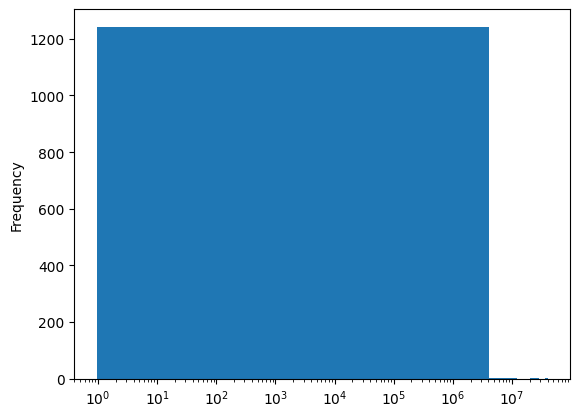

In [97]:
data_at_a_station["forward_diff_org"].plot(kind='hist',logx=True)

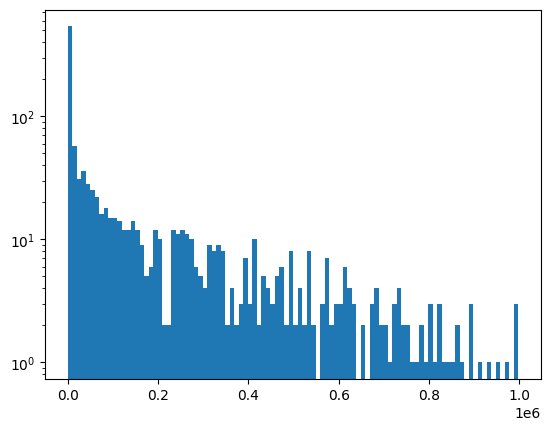

In [106]:
plt.hist(forward_diff_org[forward_diff_org<1e6],100,log=True);
# plt.xscale("log")
# plt.xlim([0,15000])

In [65]:
np.unique([repr(type(x)) for x in forward_diff_org])
types=[repr(type(x)) for x in forward_diff_org]


In [67]:
print(np.unique(types))

["<class 'float'>"]


# Japan

In [190]:
org_time=cat.iloc[0]["source_origin_time"]

In [191]:
org_time

2004-04-01T00:16:40.830000Z

In [192]:
datetime.fromisoformat((org_time - 0.5).isoformat())

datetime.datetime(2004, 4, 1, 0, 16, 40, 330000)

In [14]:
from HinetPy import Client
client = Client("zyy123", "zhong95")
data2, ctable2 = client.get_continuous_waveform("0101", "201012010000", span=2,outdir="test")

[2023-09-14 16:09:53] INFO: 2010-12-01 00:00 ~2
[2023-09-14 16:09:53] INFO: [1/1] => 2010-12-01 00:00 ~2


In [18]:
from obspy import Stream

In [16]:
def _read_sac_files(data_dir):
    sac_files = list(data_dir.glob("*.SAC"))
    sts = Stream()
    for sac in sac_files:
        st = read(sac)
        sts += st
    return sts

In [31]:
HinetPy.win32.extract_sac(
    data2,
    ctable2,
    filter_by_name=["N.AGWH"],
    outdir=data2.split(".")[0],
)

[2023-09-14 16:14:47] INFO: 2342 channels found in test/0101_20101201.ch.
[2023-09-14 16:14:47] INFO: 3 channels to be extracted.
[2023-09-14 16:15:05] INFO: 3 SAC data successfully extracted.


In [32]:
st=_read_sac_files(Path(data2.split(".")[0]))

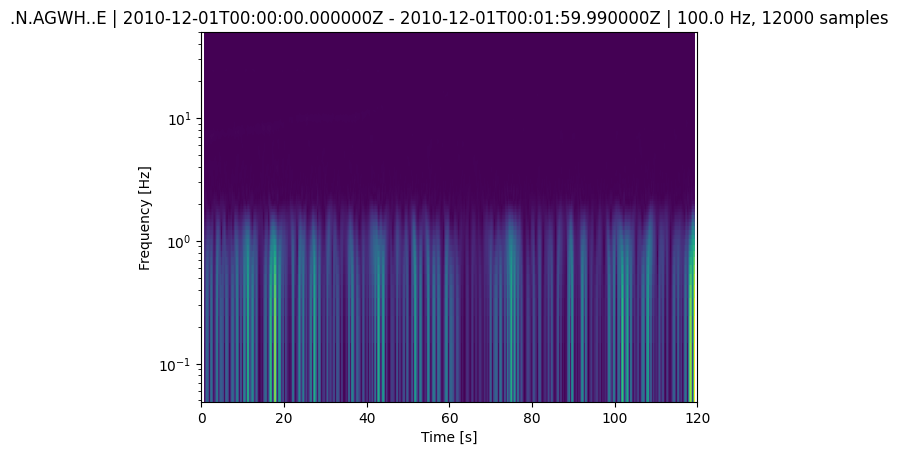

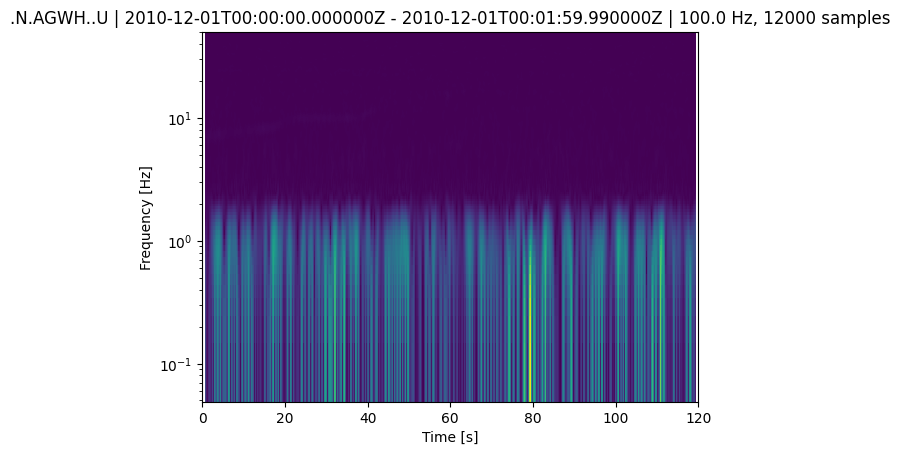

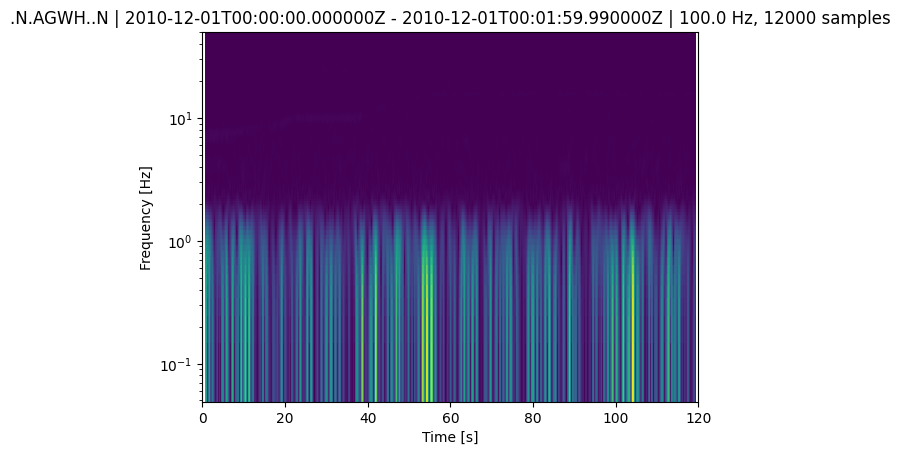

In [36]:
st.spectrogram(log=True);


'test/0101_201012010000_2.cnt'

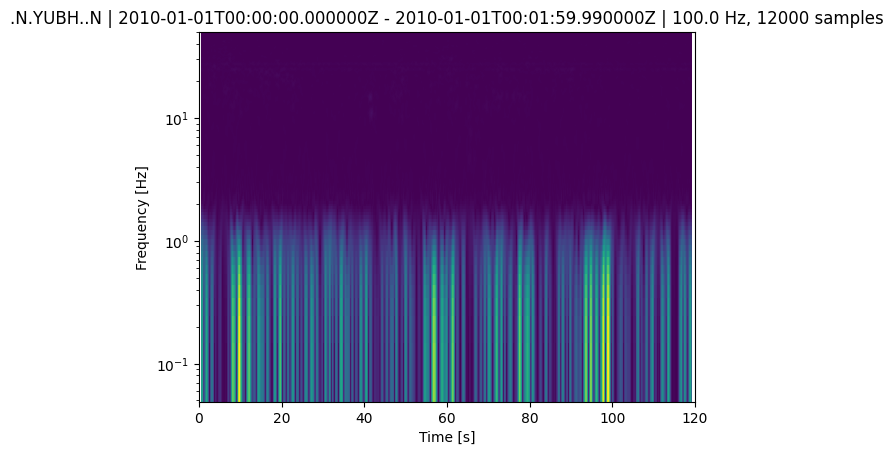

In [177]:
st[26].spectrogram(log=True);

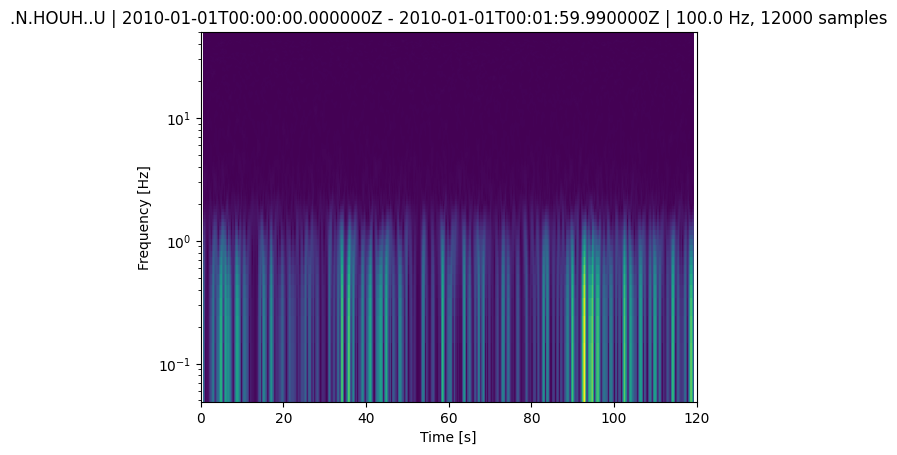

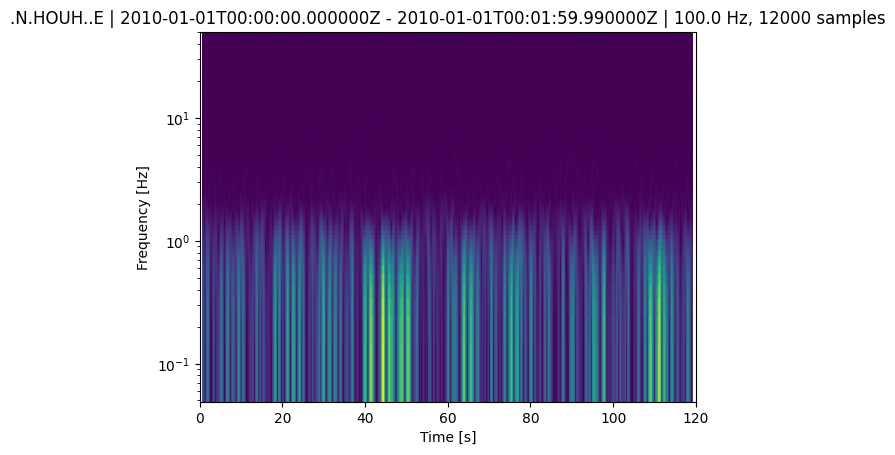

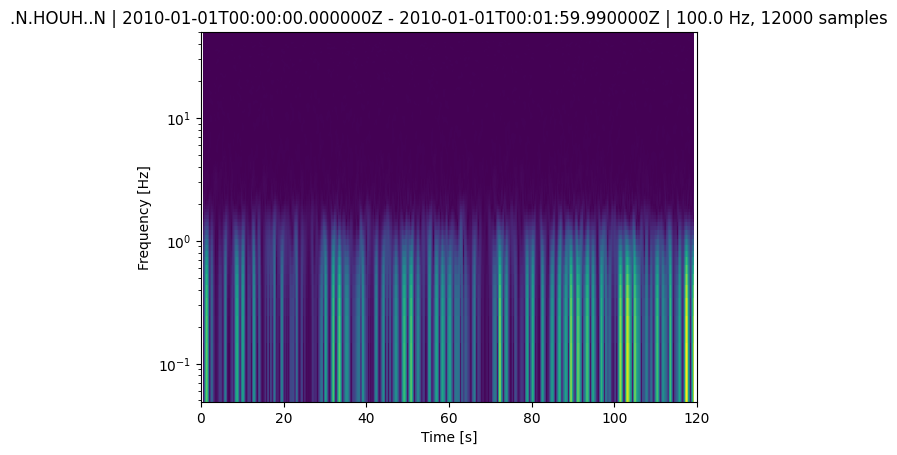

In [147]:
st.spectrogram(log=True);

In [ ]:
str(st[0].stats.starttime).replace("-","").replace(":","")[2:-4]

'090824T002003.000'

In [151]:
stations=list(np.unique(np.append(np.unique(japan_vol_LP_with_PS["station_code"].values),np.unique(japan_VT_with_PS["station_code"].values))))

In [153]:
HinetPy.win32.extract_sac(
    data,
    ctable,
    filter_by_name=stations,
    outdir=data.split(".")[0],
)

[2023-09-14 13:10:10] INFO: 2336 channels found in test/0101_20100101.ch.
[2023-09-14 13:10:10] INFO: 1482 channels to be extracted.
[2023-09-14 13:12:59] WARNING: Data for N.SNBH.U (7063) not exists. Skipped.
[2023-09-14 13:13:09] WARNING: Data for N.SNBH.N (7064) not exists. Skipped.
[2023-09-14 13:13:09] WARNING: Data for N.KRKH.U (71b3) not exists. Skipped.
[2023-09-14 13:13:18] WARNING: Data for N.SNBH.E (7065) not exists. Skipped.
[2023-09-14 13:13:19] WARNING: Data for N.KRKH.N (71b4) not exists. Skipped.
[2023-09-14 13:13:21] WARNING: Data for N.NSHH.U (7813) not exists. Skipped.
[2023-09-14 13:13:26] WARNING: Data for N.KRKH.E (71b5) not exists. Skipped.
[2023-09-14 13:13:28] WARNING: Data for N.NSHH.N (7814) not exists. Skipped.
[2023-09-14 13:13:33] WARNING: Data for N.NSHH.E (7815) not exists. Skipped.
[2023-09-14 13:13:48] INFO: 1473 SAC data successfully extracted.


In [66]:
a=st.select(station="N.YTOH")

In [69]:
a[0].stats

         network: 
         station: N.YTOH
        location: 
         channel: E
       starttime: 2010-01-01T00:00:00.000000Z
         endtime: 2010-01-01T00:01:59.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 12000
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.01, 'b': 0.0, 'stla': 36.5711, 'stlo': 137.1595, 'stel': -92.0, 'cmpaz': 90.0, 'cmpinc': 90.0, 'nzyear': 2010, 'nzjday': 1, 'nzhour': 0, 'nzmin': 0, 'nzsec': 0, 'nzmsec': 0, 'nvhdr': 6, 'npts': 12000, 'iftype': 1, 'idep': 7, 'ievtyp': 40, 'leven': 1, 'lpspol': 0, 'lovrok': 1, 'lcalda': 1, 'unused23': 0, 'kstnm': 'N.YTOH', 'kevnm': 'Hi-net', 'kcmpnm': 'E'})

In [61]:
st

1476 Trace(s) in Stream:

.N.AKNH..U | 2010-01-01T00:00:00.000000Z - 2010-01-01T00:01:59.990000Z | 100.0 Hz, 12000 samples
...
(1474 other traces)
...
.N.HHIH..E | 2010-01-01T00:00:00.000000Z - 2010-01-01T00:01:59.990000Z | 100.0 Hz, 12000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [60]:
st.select(station=stations[0])

0 Trace(s) in Stream:


In [52]:
st

1476 Trace(s) in Stream:

.N.AKNH..U | 2010-01-01T00:00:00.000000Z - 2010-01-01T00:01:59.990000Z | 100.0 Hz, 12000 samples
...
(1474 other traces)
...
.N.HHIH..E | 2010-01-01T00:00:00.000000Z - 2010-01-01T00:01:59.990000Z | 100.0 Hz, 12000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [70]:
st=_read_sac_files(Path("japan_download_temp_files/D20040402212900_20"))

In [72]:
st[0].stats

         network: 
         station: N.AYWH
        location: 
         channel: U
       starttime: 2004-04-02T15:49:24.000000Z
         endtime: 2004-04-02T15:50:14.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 5100
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.01, 'b': 24.0, 'stla': 43.2708, 'stlo': 143.4317, 'stel': -2.0, 'cmpaz': 0.0, 'cmpinc': 0.0, 'nzyear': 2004, 'nzjday': 93, 'nzhour': 15, 'nzmin': 49, 'nzsec': 0, 'nzmsec': 0, 'nvhdr': 6, 'npts': 5100, 'iftype': 1, 'idep': 7, 'ievtyp': 40, 'leven': 1, 'lpspol': 0, 'lovrok': 1, 'lcalda': 1, 'unused23': 0, 'kstnm': 'N.AYWH', 'kevnm': 'Hi-net', 'kcmpnm': 'U'})

In [85]:
df2 = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9],[10, 11, 12],[13, 14, 15],[16, 17, 18],[19, 20, 21]]),
                   columns=['a', 'b', 'c'])

In [86]:
df2.iloc[np.arange(2,8,2)]

,a,b,c
2,7,8,9
4,13,14,15
6,19,20,21


In [76]:
aa=np.array([1,2,3,4,6,123,341,-2,12])

In [75]:
np.arange(2,8,2)

array([2, 4, 6])

In [77]:
aa.iloc[np.arange(2,8,2)]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [51]:
st[601].stats.sac


AttribDict({'delta': 0.01, 'b': 0.0, 'stla': 37.5438, 'stlo': 139.3648, 'stel': 116.0, 'cmpaz': 0.0, 'cmpinc': 90.0, 'nzyear': 2010, 'nzjday': 1, 'nzhour': 0, 'nzmin': 0, 'nzsec': 0, 'nzmsec': 0, 'nvhdr': 6, 'npts': 12000, 'iftype': 1, 'idep': 7, 'ievtyp': 40, 'leven': 1, 'lpspol': 0, 'lovrok': 1, 'lcalda': 1, 'unused23': 0, 'kstnm': 'N.KMKH', 'kevnm': 'Hi-net', 'kcmpnm': 'N'})

In [40]:
st[1].stats

         network: 
         station: N.AGWH
        location: 
         channel: U
       starttime: 2010-12-01T00:00:00.000000Z
         endtime: 2010-12-01T00:01:59.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 12000
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.01, 'b': 0.0, 'stla': 43.0842, 'stlo': 140.8199, 'stel': -77.0, 'cmpaz': 0.0, 'cmpinc': 0.0, 'nzyear': 2010, 'nzjday': 335, 'nzhour': 0, 'nzmin': 0, 'nzsec': 0, 'nzmsec': 0, 'nvhdr': 6, 'npts': 12000, 'iftype': 1, 'idep': 7, 'ievtyp': 40, 'leven': 1, 'lpspol': 0, 'lovrok': 1, 'lcalda': 1, 'unused23': 0, 'kstnm': 'N.AGWH', 'kevnm': 'Hi-net', 'kcmpnm': 'U'})

In [2]:
cat=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/japan_catalog.csv")

In [53]:
japan_vol_LP_with_PS=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/japan_vol_LP_with_PS.csv")
japan_VT_with_PS=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/japan_VT_with_PS.csv")

In [56]:
stations=list(np.unique(np.append(np.unique(japan_vol_LP_with_PS["station_code"].values),np.unique(japan_VT_with_PS["station_code"].values))))

In [54]:
len(np.unique(np.append(np.unique(japan_vol_LP_with_PS["station_code"].values),np.unique(japan_VT_with_PS["station_code"].values))))

951

In [16]:
len(cat)

61574412

In [76]:
def get_event_end(x):
    if pd.notna(x["trace_p_arrival_time"]) and pd.notna(
        x["trace_s_arrival_time"]
    ):
        if x["trace_p_arrival_time"] < x["trace_s_arrival_time"]:
            return (
                x["trace_p_arrival_time"]
                + (x["trace_s_arrival_time"] - x["trace_p_arrival_time"]) * 5
                + 60
            )
        else:
            return x["source_origin_time"] + 600
    elif pd.notna(x["trace_p_arrival_time"]):
        return x["trace_p_arrival_time"] + 600
    else:
        return x["source_origin_time"] + 600

In [18]:
cat["source_origin_time"] = cat["source_origin_time"].apply(
    lambda x: UTCDateTime(x) if pd.notna(x) else np.nan
)
cat["trace_p_arrival_time"] = cat[
    "trace_p_arrival_time"
].apply(lambda x: UTCDateTime(x) if pd.notna(x) else np.nan)
cat["trace_s_arrival_time"] = cat[
    "trace_s_arrival_time"
].apply(lambda x: UTCDateTime(x) if pd.notna(x) else np.nan)

In [19]:
cat["event_end"]=cat["source_origin_time"]+120*60

In [20]:
cat.sort_values(by=["source_origin_time"], inplace=True)

In [26]:
cat["source_origin_time"]

0           2004-04-01T00:16:40.830000Z
1           2004-04-01T00:16:40.830000Z
2           2004-04-01T00:16:40.830000Z
3           2004-04-01T00:16:40.830000Z
4           2004-04-01T00:16:40.830000Z
                       ...             
61574395    2023-06-28T23:59:34.720000Z
61574394    2023-06-28T23:59:34.720000Z
61574410    2023-06-28T23:59:34.720000Z
61574401    2023-06-28T23:59:34.720000Z
61574411    2023-06-28T23:59:34.720000Z
Name: source_origin_time, Length: 61574412, dtype: object

In [66]:
cat["event_end"]=cat["source_origin_time"]+300

In [4]:
events=cat.drop_duplicates(
        subset="source_id", keep="first", ignore_index=True
    ).copy()
events["source_origin_time"] = events["source_origin_time"].apply(
    lambda x: UTCDateTime(x) if pd.notna(x) else np.nan
)
events.sort_values(by=["source_origin_time"], inplace=True)
events["event_end"]=events["source_origin_time"]+600

In [5]:
time_difference_limit=2600
forward_event_time_diff = (
    events["source_origin_time"].values[1:]
    - events["event_end"].values[:-1]
).astype(float)

forward_event_time_diff = np.append(forward_event_time_diff, np.nan)
events["forward_event_time_difference"] = forward_event_time_diff
events["next_event_origin_time"] = np.append(
    events["source_origin_time"][1:].values, np.nan
)

events2=events.sort_values(
    by=["forward_event_time_difference"], ascending=False, inplace=False
)
events2 = events2[
    pd.notna(events2["forward_event_time_difference"])
    & (events2["forward_event_time_difference"] > time_difference_limit)
]

In [6]:
len(events2)

59

In [13]:
98*500*2

98000

In [123]:
len(events2)

1789911

In [124]:
1789911-1791263

-1352

In [43]:
cat["station_code"]

0           N.SAMH
1           NOBUKA
2           HU.KMU
3           HU.MYR
4           N.TKIH
             ...  
61574395    N.TKKH
61574394    TAMANA
61574410    KU.SMT
61574401    URESHI
61574411    N.UMIH
Name: station_code, Length: 61574412, dtype: object

In [80]:
np.sum(forward_event_time_diff>1200)

26307

In [95]:
time_difference_limit=3600*24

subcatalog=cat[cat["station_code"]=="N.SAMH"].copy()
subcatalog.sort_values(by=["source_origin_time"], inplace=True)
# subcatalog["event_end"]=subcatalog["source_origin_time"]+1800
subcatalog["event_end"] = subcatalog.apply(get_event_end, axis=1)
len(subcatalog)

forward_event_time_diff = (
    subcatalog["source_origin_time"].values[1:]
    - subcatalog["event_end"].values[:-1]
).astype(float)

forward_event_time_diff = np.append(forward_event_time_diff, np.nan)
subcatalog["forward_event_time_difference"] = forward_event_time_diff
subcatalog["next_event_origin_time"] = np.append(
    subcatalog["source_origin_time"][1:].values, np.nan
)

subcatalog.sort_values(
    by=["forward_event_time_difference"], ascending=False, inplace=True
)
subcatalog = subcatalog[
    pd.notna(subcatalog["forward_event_time_difference"])
    & (subcatalog["forward_event_time_difference"] > time_difference_limit)
]
# subcatalog = subcatalog.iloc[:number_records_each_station].copy()
# subcatalog.reset_index(inplace=True)

In [96]:
len(subcatalog)

647

In [71]:
len(cat.iloc[:-1][forward_event_time_diff>2400]["source_id"].unique())

210

(array([6.1574408e+07, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]),
 array([  -3600.   ,  238328.839,  480257.678,  722186.517,  964115.356,
        1206044.195, 1447973.034, 1689901.873, 1931830.712, 2173759.551,
        2415688.39 ]),
 <BarContainer object of 10 artists>)

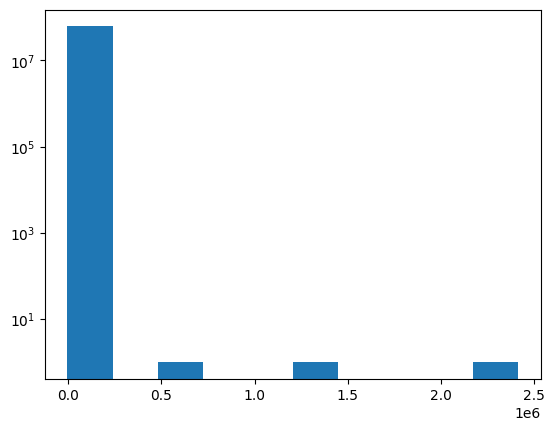

In [33]:
plt.hist(forward_event_time_diff,log=True)